In [1]:
""""
Figaro times collection times script. 
"""
import numpy as np
import pandas as pd
import os
from openpyxl import load_workbook, Workbook
from openpyxl.utils.cell import get_column_letter

path_src = "/local/scratch/Figaro/figaro-code"
#exp_names = ["figaro_mkl", "mkl", "postprocess_lapack", "openblas"]
exp_names = ["figaro_thin_diag", "postprocess_lapack", "postprocess_thin"]
#exp_names = ["figaro_mkl", "figaro_thin_diag", "postprocess_thin", "postprocess_lapack"]
#exp_names = ["postprocess_lapack", "mkl"]
#exp_names = ["mkl","openblas"]
exp_paths = {"figaro_mkl": "comparisons/performance/figaro/lapack", 
"figaro_thin_diag": "comparisons/performance/figaro/thin_diag", 
"mkl": "comparisons/performance/python/mkl",
"openblas": "comparisons/performance/python/openblas",
"postprocess_lapack": "comparisons/performance/postprocess/lapack",
"postprocess_thin": "comparisons/performance/postprocess/thin_diag",}
db_names = ["DBRetailer", "DBFavorita", "DBYelp"]
#db_names = ["DBRetailer"]
#db_names = ["DBFavorita"]
#db_names = ["DBYelp"]

start_per = 10
end_per = 100
per_inc = 10

num_measurement = 5

xlsx_name = "time.xlsx"


join_orders = {"DBRetailer": "ItemRoot48",
"DBFavorita": "ItemsRoot48", "DBYelp": "UserRoot48"}

df_measurement_exps = {}
for exp_name in exp_names: 
    exp_path = exp_paths[exp_name]
    perf_path = os.path.join(path_src, exp_path)
    df_measurement = pd.DataFrame(columns=db_names)

    for db_name in db_names:
        #gather_times_path = os.path.join(perf_path, db_name + xlsx_name)
        #print(gather_times_path)
        #out_workbook = Workbook()
        #out_workbook.remove(out_workbook.active)
        #out_sheet = out_workbook.create_sheet("Times")

        for db_idx, percent in enumerate(range(start_per, end_per + 1, per_inc)): 
            db_name_per = "{}PK1C{}".format(db_name, percent)
            join_order = join_orders[db_name]
            path_xlsx = os.path.join(perf_path, db_name_per, join_order, xlsx_name)
            #path_xlsx = os.path.join(perf_path, db_name_per, xlsx_name)
            print(path_xlsx)
            workbook = load_workbook(filename=path_xlsx, data_only=True)
            sheet = workbook.active
            row_count = sheet.max_row
            col_idx = db_idx + 1
            col_letter = get_column_letter(col_idx)
            
            #out_sheet.cell(row=1, column=col_idx).value = db_name_per
            
            start_row_idx = 2
            np_measures = np.zeros(num_measurement)
            for row_idx_dst in range(start_row_idx, start_row_idx + num_measurement):
                offset_idx = row_idx_dst - start_row_idx
                row_idx_src = row_count - num_measurement  + offset_idx
                val = sheet.cell(row=row_idx_src, column=2).value
                np_measures[offset_idx] = float(val)
                #print(idx_shift, db_idx)
                #out_sheet.cell(row=row_idx_dst, column=col_idx).value = val
            
            #out_sheet.cell(row=start_row_idx + num_measurement, column=col_idx).value = '=AVERAGE({}{}:{}{})'.format(col_letter, start_row_idx + 1, 
            #        col_letter,6)

            time_avg = np.mean(np_measures[1:])
            df_measurement.at[percent, db_name] = time_avg
            
        #out_workbook.save(gather_times_path)
        print(df_measurement)
        df_measurement.index = df_measurement.index.set_names(['index'])
        df_measurement = df_measurement.astype(float)
    df_measurement_exps[exp_name] = df_measurement





/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C10/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C20/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C30/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C40/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C50/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C60/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C70/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C80/ItemRoot48/time.xlsx
/local/scratch/Figaro/figaro-code/comparisons/performance/figaro/thin_diag/DBRetailerPK1C90/Item

In [2]:
import csv
db_name_map = {
    "DBFavorita": "exp1perf-favorita.dat", 
    "DBRetailer": "exp1perf-retailer.dat", 
    "DBYelp": "exp1perf-yelp.dat"
    }
exp_dat_names = ["#percentage of data", "figaro-time", "mkl-time", "thin-time"]
for db_name in db_names:
    dbs_results = []
    for exp_name in exp_names:
        dbs_results.append(df_measurement_exps[exp_name][db_name])
    df_db_results = pd.concat(dbs_results, axis=1)
    df_db_results = df_db_results.reset_index().rename(columns={df_db_results.index.name:'index'})
    df_db_results.columns = exp_dat_names
    df_db_results.to_csv(db_name_map[db_name], float_format='%.2f', sep='\t', index=False, quoting=csv.QUOTE_NONE,  escapechar=" ")
"""
"""

'\n'

In [3]:
#df_measurement_exps["figaro_thin_diag"] / df_measurement_exps["figaro_mkl"]

{'figaro_thin_diag':        DBRetailer  DBFavorita    DBYelp
index                                  
10       0.705675    1.092300  0.086573
20       1.459115    2.579828  0.080460
30       2.449990    2.893178  0.088091
40       3.549920    3.971757  0.078235
50       4.936607    5.315027  0.087004
60       6.440350    6.313460  0.083391
70      14.592066    7.876188  0.072979
80      10.370458    9.267266  0.072424
90      21.797637   17.948090  0.088833
100     26.791975   13.394123  0.079606, 'postprocess_lapack':        DBRetailer  DBFavorita    DBYelp
index                                  
10       2.519716    2.977780  0.477447
20       5.408195    8.587518  0.473389
30       8.187370   10.249530  0.485025
40      12.168507   14.196690  0.481341
50      15.442320   20.393472  0.497470
60      18.542353   21.634216  0.492391
70      25.776613   27.780865  0.478089
80      26.588580   33.222438  0.486131
90      32.807394   38.331641  0.473961
100     38.329654   43.597529  0.475

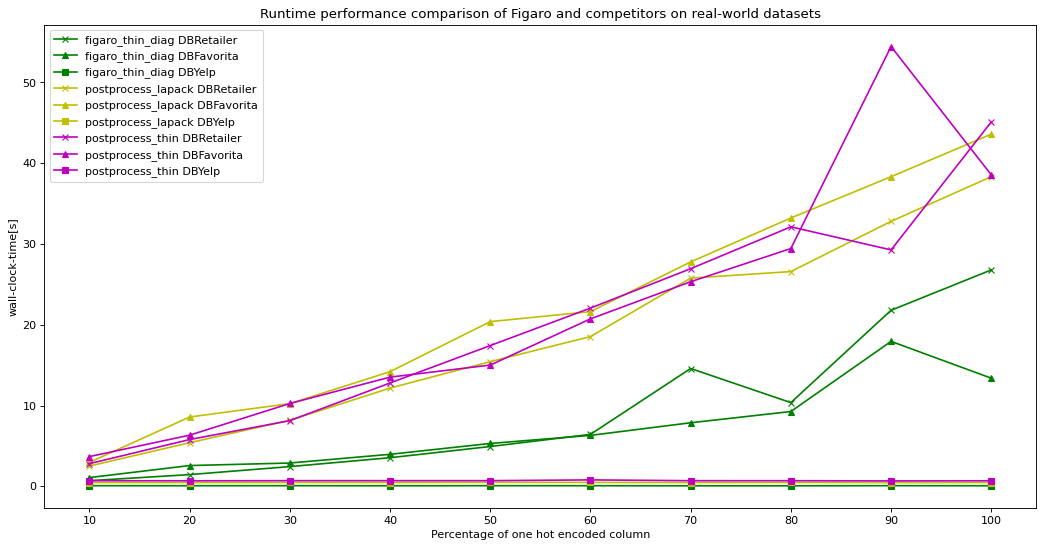

In [4]:
import matplotlib.pyplot as plt

plt.figure("name", figsize=(16, 8), dpi=80)
plt.xlabel("Percentage of one hot encoded column")
plt.ylabel("wall-clock-time[s]")

plt.title("Runtime performance comparison of Figaro and competitors on real-world datasets")

plt.yscale('linear')
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='x', nbins=10)
db_marker =  {"DBFavorita": "^", "DBYelp": "s", "DBRetailer": "x"}
exp_colour = {"figaro_mkl": "r", "figaro_thin_diag": 'g', "mkl": "b", "postprocess_lapack": "y", "postprocess_thin": "m", "openblas": "c"}

print(df_measurement_exps)
for exp_name in exp_names:
    print(exp_name)
    df_measurement = df_measurement_exps[exp_name]
    for db_name in df_measurement:
        print(df_measurement[db_name])
        plt.plot(df_measurement[db_name], "-" + exp_colour[exp_name] + db_marker[db_name], label="{} {}".format(exp_name, db_name))
plt.legend(loc="upper left")

plt.show()